In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [16]:
if os.path.isfile('beforewv.csv'):
    data = pd.read_csv("beforewv.csv",encoding='latin-1')

In [17]:

data.head()

,word_Common,word_share,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,is_duplicate
0,10,0.434783,100,93,93,100,0.982759,0
1,4,0.200000,86,63,66,75,0.596154,0
2,4,0.166667,63,63,43,47,0.166667,0
3,0,0.000000,28,24,9,14,0.039216,0
4,2,0.100000,67,47,35,56,0.175000,0


In [18]:
y_true = data['is_duplicate']
data.drop(['is_duplicate'], axis=1, inplace=True)

In [19]:
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)

In [20]:
y_true = list(map(int, y_true.values))

In [21]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [22]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (140000, 7)
Number of data points in test data : (60000, 7)


In [23]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6276285714285714 Class 1:  0.3723714285714286
---------- Distribution of output variable in train data ----------
Class 0:  0.6276166666666667 Class 1:  0.37238333333333334


In [24]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2>Random Model</h2>

Log loss on Test Data using Random Model 0.8886007193951257


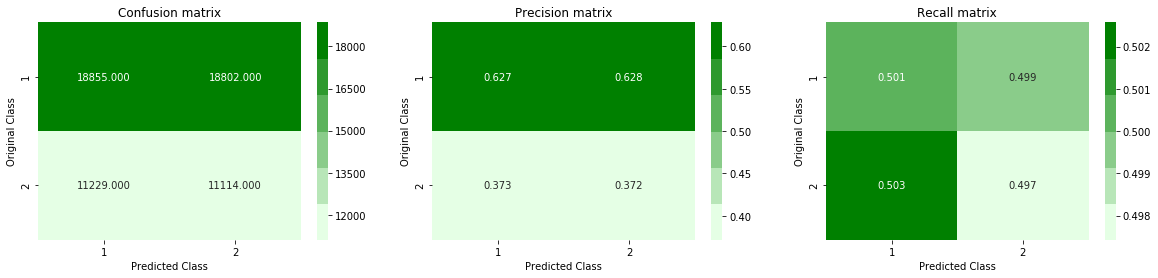

F1 Score is :  0.49101105958200797


In [25]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)
print("F1 Score is : ", f1_score(y_test, predicted_y, average='macro'))

<h2>Logistic</h2>

For values of alpha =  1e-05 The log loss is: 0.5656827082782748
For values of alpha =  0.0001 The log loss is: 0.566769337917199
For values of alpha =  0.001 The log loss is: 0.5679306185911833
For values of alpha =  0.01 The log loss is: 0.568856507050381
For values of alpha =  0.1 The log loss is: 0.5644414992694127
For values of alpha =  1 The log loss is: 0.611982487096582
For values of alpha =  10 The log loss is: 0.6293024869167221


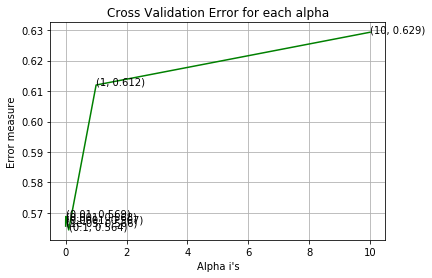

For values of best alpha =  0.1 The train log loss is: 0.5638806320890577
For values of best alpha =  0.1 The test log loss is: 0.5644414992694127
Total number of data points : 60000


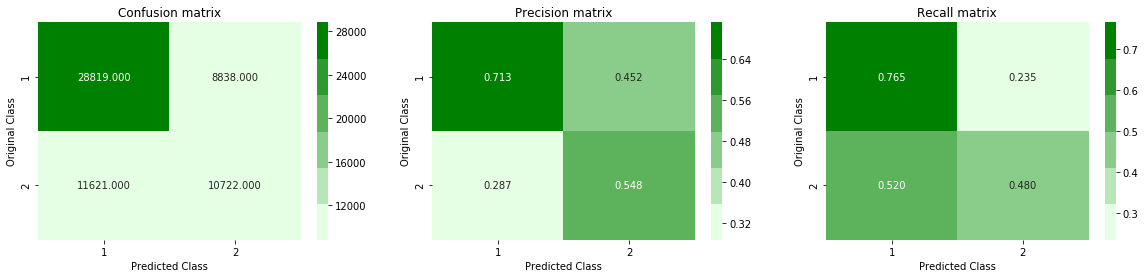

F1 Score is :  0.6248921226808253


In [55]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
print("F1 Score is : ", f1_score(y_test, predicted_y, average='macro'))

<h2>SVM</h2>

For values of alpha =  1e-05 The log loss is: 0.5667447048080214
For values of alpha =  0.0001 The log loss is: 0.5683004086432858
For values of alpha =  0.001 The log loss is: 0.5689252190891224
For values of alpha =  0.01 The log loss is: 0.5667815367452557
For values of alpha =  0.1 The log loss is: 0.5668914357356526
For values of alpha =  1 The log loss is: 0.588235629297827
For values of alpha =  10 The log loss is: 0.6247730156344604


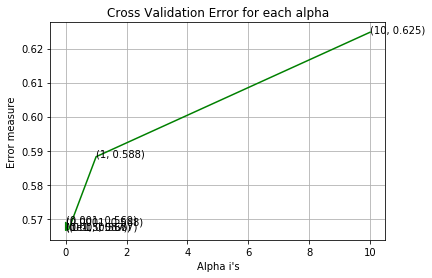

For values of best alpha =  1e-05 The train log loss is: 0.5670246500784107
For values of best alpha =  1e-05 The test log loss is: 0.5667447048080214
Total number of data points : 60000


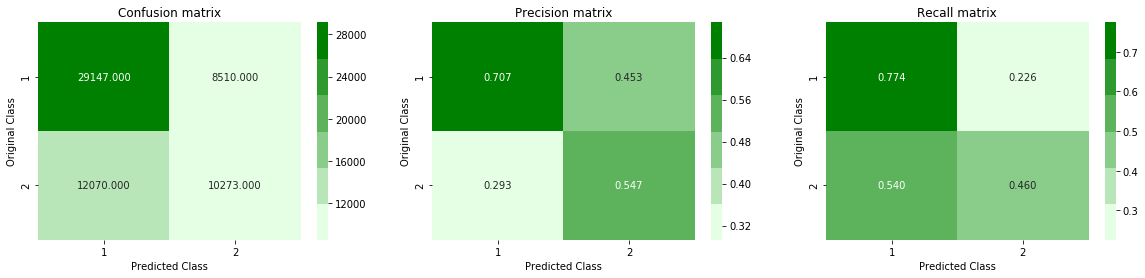

F1 Score is :  0.6193320761147277


In [54]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
print("F1 Score is : ", f1_score(y_test, predicted_y, average='macro'))

<h2>XGBoost</h2>

In [52]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[00:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.687586	valid-logloss:0.687581
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[00:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:48] C:\Users\Administrator\Desktop\xg

[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[00:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:29:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:29:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[110]	train-logloss:0.516109	valid-logloss:0.517446
[00:29:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:29:57] C:\Users\Administrator\Desktop\

[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[160]	train-logloss:0.50548	valid-logloss:0.507244
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:30:01] C:\Users\Administrator\Desktop\x

[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[00:30:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:30:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[00:30:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:30:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:30:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[270]	train-logloss:0.496771	valid-logloss:0.499056
[00:30:09] C:\Users\Administrator\Desktop\

[00:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[320]	train-logloss:0.494461	valid-logloss:0.49696
[00:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:30:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:30:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:14] C:\Users\Administrator\Desktop\x

[00:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[00:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[00:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[00:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[00:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[00:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

Total number of data points : 60000


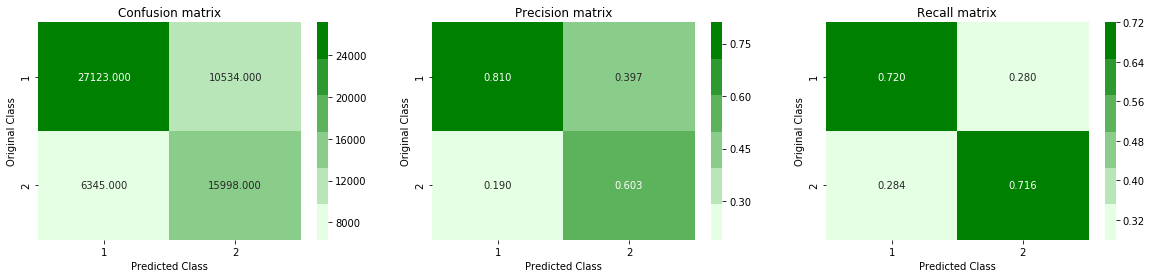

F1 Score is :  0.7086675146867794


In [53]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
print("F1 Score is : ", f1_score(y_test, predicted_y, average='macro'))

In [46]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
predict_y = clf.predict_proba(X_test)
print("The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)

The log loss is: 11.138147297926977
Total number of data points : 60000


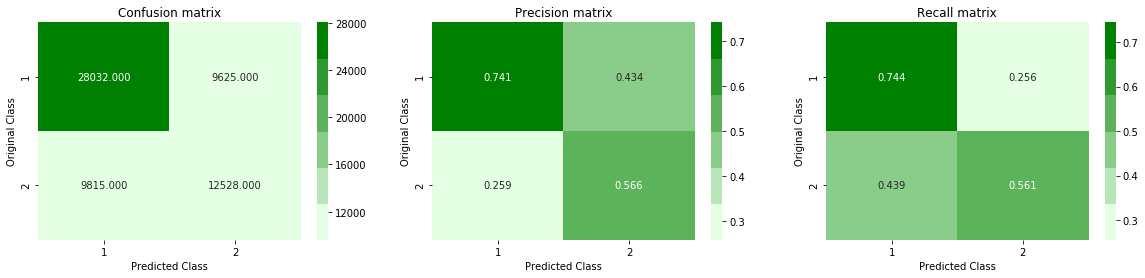

F1 Score is :  0.6528184965960782


In [47]:
from sklearn.metrics import f1_score

plot_confusion_matrix(y_test, predicted_y)
print("F1 Score is : ", f1_score(y_test, predicted_y, average='macro'))

<h2>Random Forest</h2>

The log loss is: 0.49020682099668805
Total number of data points : 60000


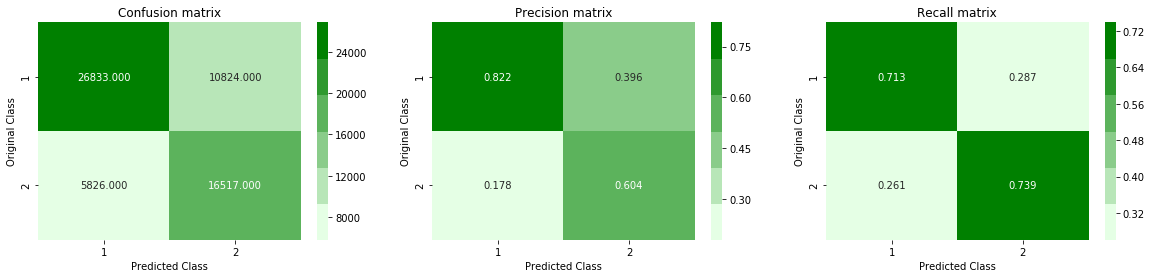

F1 Score is :  0.7140469206880173


In [26]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predict_y = clf.predict_proba(X_test)
print("The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
print("F1 Score is : ", f1_score(y_test, predicted_y, average='macro'))